# Malaria Detection

## Importing Libraries

In [1]:
!pip install torchsummary


In [35]:
import os                       # for working with files
import numpy as np              # for numerical computationss
import pandas as pd             # for working with dataframes
import torch                    # Pytorch module 
import matplotlib.pyplot as plt # for plotting informations on graph and images using tensors
import torch.nn as nn           # for creating  neural networks
from torch.utils.data import DataLoader, random_split # for dataloaders 
from PIL import Image           # for checking images
import torch.nn.functional as F # for functions for calculating loss
import torchvision.transforms as transforms   # for transforming images into tensors 
from torchvision.utils import make_grid       # for data checking
from torchvision.datasets import ImageFolder  # for working with classes and images
from torchsummary import summary              # for getting the summary of our model
import random
import cv2
%matplotlib inline

In [3]:
data_dir = "/kaggle/input/cell-images-for-detecting-malaria/cell_images/cell_images"

categories = os.listdir(data_dir)
print(categories)

['Uninfected', 'Parasitized']


In [4]:
for i in categories:
    count = len(os.listdir(data_dir + '/'+i))
    print(f'There are {count} ,{i} Images')

There are 13780 ,Uninfected Images
There are 13780 ,Parasitized Images


Given data is  Balanced Data

Parasatized_image shape is (175, 154, 3)
Uninfected_image shape is (133, 130, 3)


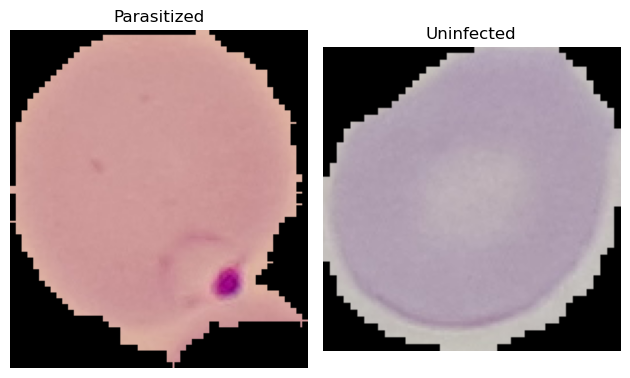

In [5]:
import matplotlib.image as mpimg

# Random Paths of Parasitized and uninfected Images
parasitized_image_path = data_dir + '/Parasitized/' + random.choice(os.listdir(data_dir + '/'+'Parasitized'))
uninfected_image_path = data_dir + '/Uninfected/' + random.choice(os.listdir(data_dir + '/'+'Uninfected'))

parasitized_image = mpimg.imread(parasitized_image_path)
uninfected_image = mpimg.imread(uninfected_image_path)
print(f'Parasatized_image shape is {parasitized_image.shape}')
print(f'Uninfected_image shape is {uninfected_image.shape}')

fig, axs = plt.subplots(1, 2)

axs[0].imshow(parasitized_image)
axs[0].set_title('Parasitized')
axs[0].axis('off')

axs[1].imshow(uninfected_image)
axs[1].set_title('Uninfected')
axs[1].axis('off')

plt.tight_layout()

# Show the figure
plt.show()


The dimensions of Images provided are not same for all, So we need to resize the images.

## Data Preparation

In [6]:
# Setting the seed value
random_seed = 7
torch.manual_seed(random_seed)

In [7]:
%%time
# datasets for validation and training

# Define the transforms for data preprocessing and augmentation
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize the images to a specific size
    transforms.ToTensor(),  # Convert images to tensors
])
dataset = ImageFolder(data_dir, transform=transform)

#  number of samples in the dataset
dataset_size = len(dataset)

# Defining the sizes for training and validation sets (80% for training, 20% for validation)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size

# Split the dataset into training and validation sets, ensuring a balanced validation set
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

# Create data loaders for training and validation sets
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


CPU times: user 229 ms, sys: 277 ms, total: 506 ms
Wall time: 19.1 s


In [8]:
dataset.classes

['Parasitized', 'Uninfected']

In [9]:
# helper function to show a batch of training instances
def show_batch(data):
    for images, labels in data:
        fig, ax = plt.subplots(figsize=(30, 30))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break

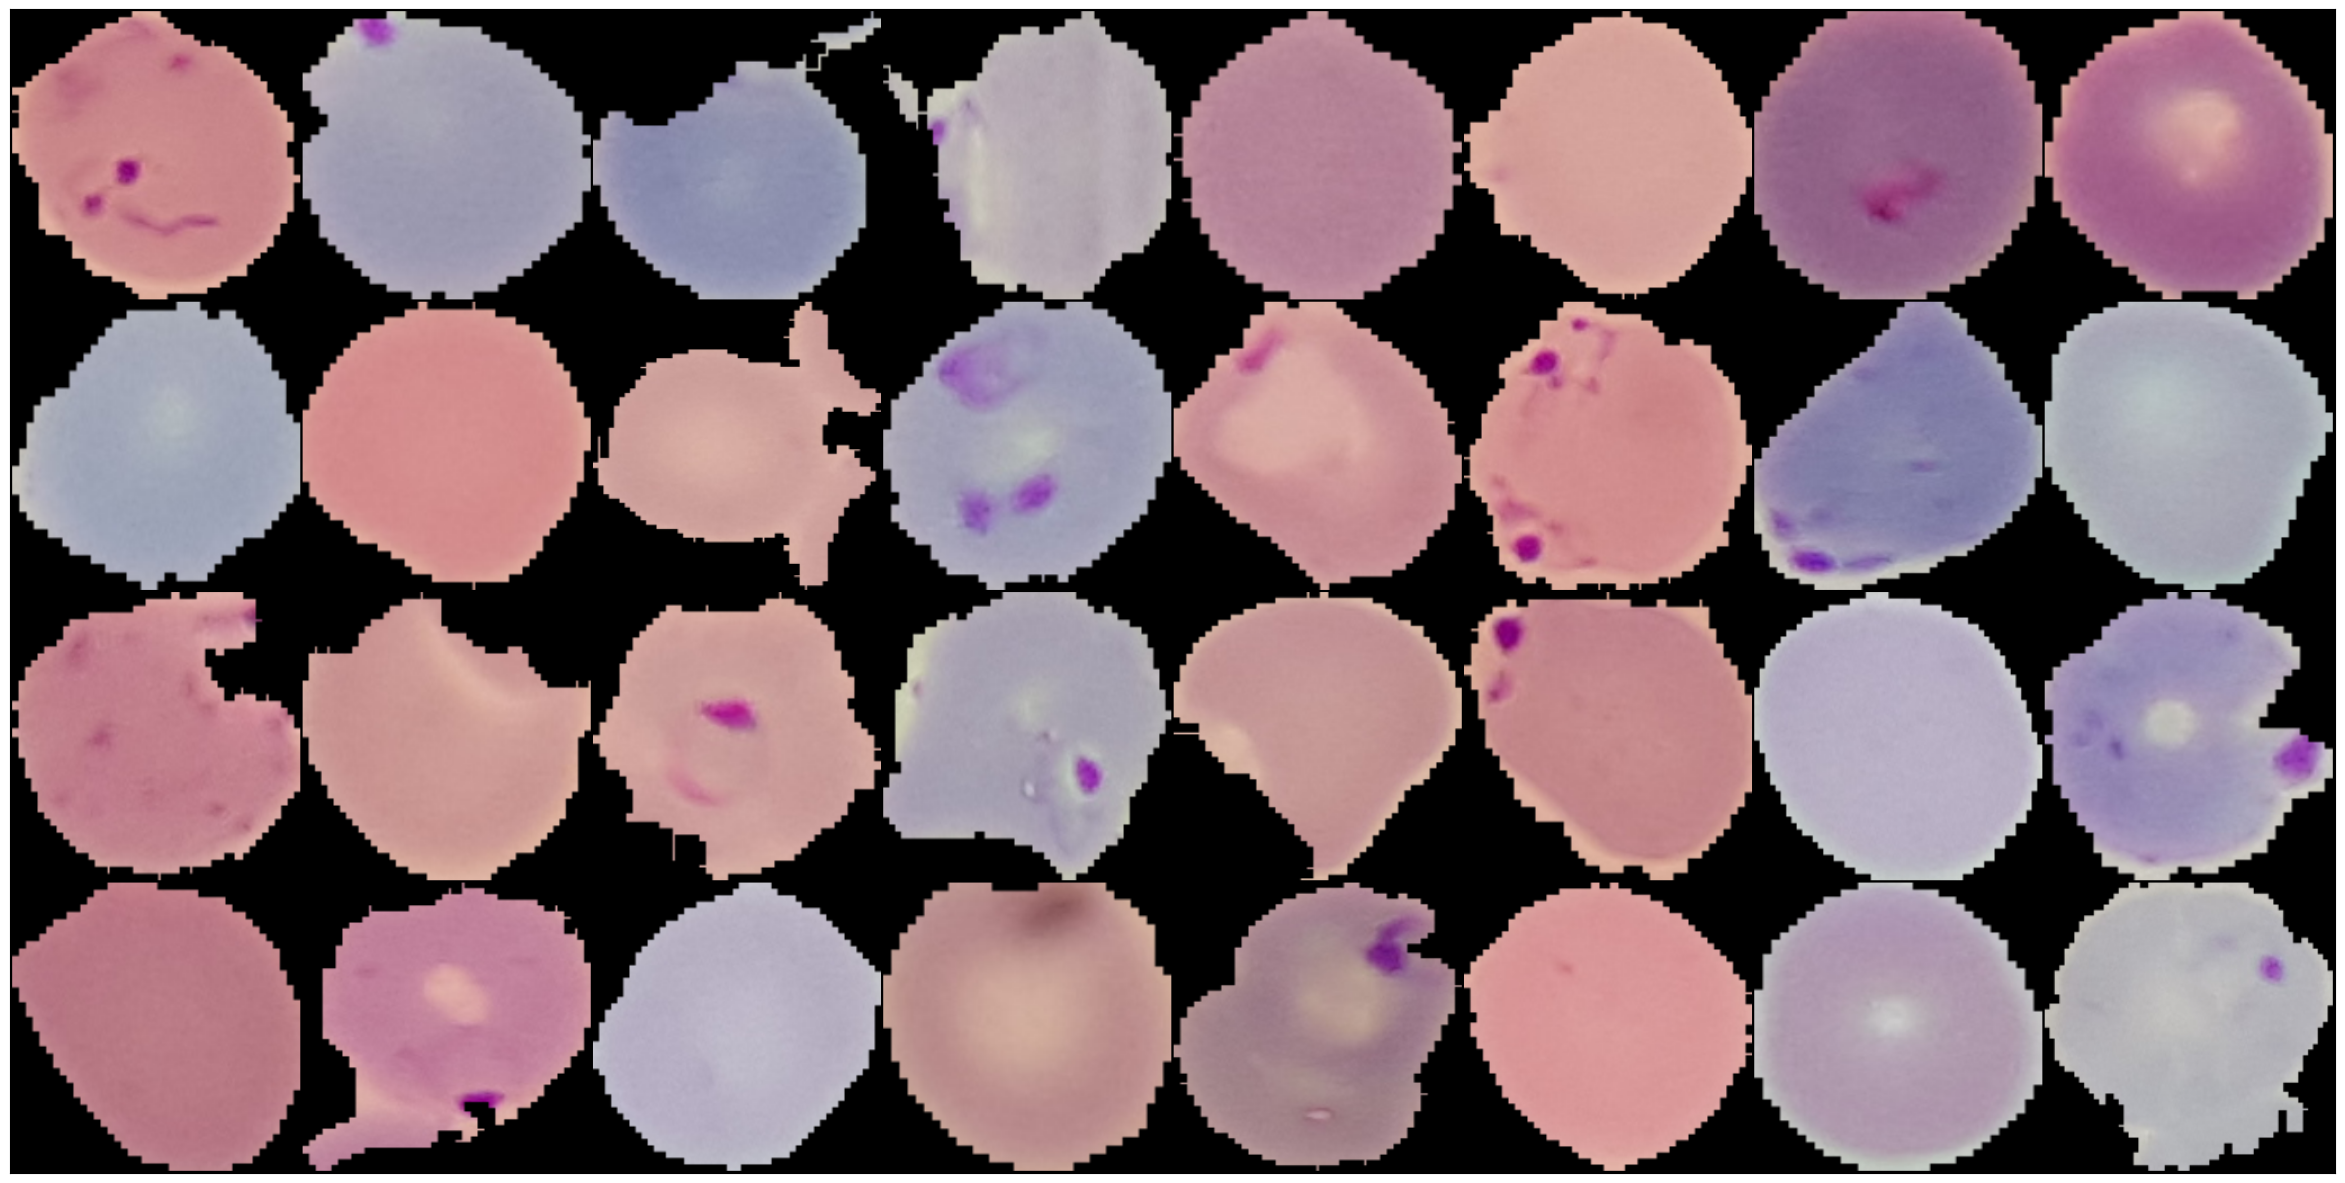

In [10]:
show_batch(train_loader)


## Helper Functions for conversion of CPU to GPU

In [11]:
# for moving data into GPU (if available)
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available:
        return torch.device("cuda")
    else:
        return torch.device("cpu")

# for moving data to device (CPU or GPU)
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# for loading in the device (GPU if available else CPU)
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)
        
    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [12]:
device = get_default_device()
device

device(type='cuda')

Wrap up our training and validation data loaders using DeviceDataLoader for automatically transferring batches of data to the GPU (if available)

In [13]:
# Moving data into GPU
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

## Modelling

In [14]:
# for calculating the accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


# base class for the model
class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                   # Generate prediction
        loss = F.cross_entropy(out, labels)  # Calculate loss
        acc = accuracy(out, labels)          # Calculate accuracy
        return {"val_loss": loss.detach(), "val_accuracy": acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        batch_accuracy = [x["val_accuracy"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       # Combine loss  
        epoch_accuracy = torch.stack(batch_accuracy).mean()
        return {"val_loss": epoch_loss, "val_accuracy": epoch_accuracy} # Combine accuracies
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_accuracy']))
        

In [15]:
# for calculating the accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


# base class for the model
class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                   # Generate prediction
        loss = F.cross_entropy(out, labels)  # Calculate loss
        acc = accuracy(out, labels)          # Calculate accuracy
        return {"val_loss": loss.detach(), "val_accuracy": acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        batch_accuracy = [x["val_accuracy"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       # Combine loss  
        epoch_accuracy = torch.stack(batch_accuracy).mean()
        return {"val_loss": epoch_loss, "val_accuracy": epoch_accuracy} # Combine accuracies
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_accuracy']))
        

### Defining the final architecture of our model

In [16]:

class CNN(ImageClassificationBase):
    def __init__(self, in_channels, num_diseases):
        super().__init__()
        
        self.conv1 = ConvBlock(in_channels, 64)
        self.conv2 = ConvBlock(64, 128, pool=True)
        self.conv3 = ConvBlock(128, 256, pool=True)
        self.conv4 = ConvBlock(256, 512, pool=True)
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                       nn.Flatten(),
                                       nn.Linear(512, num_diseases))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.classifier(out)
        return out

def ConvBlock(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(4))
    return nn.Sequential(*layers)


Now, we define a model object and transfer it into the device with which we are working...



In [17]:
# defining the model and moving it to the GPU
model = to_device(CNN(3, len(dataset.classes)), device) 
model

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, tr

In [18]:
# getting summary of the model
INPUT_SHAPE = (3, 256, 256)
print(summary(model.cuda(), (INPUT_SHAPE)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4        [-1, 128, 256, 256]          73,856
       BatchNorm2d-5        [-1, 128, 256, 256]             256
              ReLU-6        [-1, 128, 256, 256]               0
         MaxPool2d-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 256, 64, 64]         295,168
       BatchNorm2d-9          [-1, 256, 64, 64]             512
             ReLU-10          [-1, 256, 64, 64]               0
        MaxPool2d-11          [-1, 256, 16, 16]               0
           Conv2d-12          [-1, 512, 16, 16]       1,180,160
      BatchNorm2d-13          [-1, 512, 16, 16]           1,024
             ReLU-14          [-1, 512,

### Training the model

In [19]:
# for training
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    

def fit_OneCycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0,
                grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # scheduler for one cycle learniing rate
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            optimizer.step()
            optimizer.zero_grad()
            
            # recording and updating learning rates
            lrs.append(get_lr(optimizer))
            sched.step()
            
    
        # validation
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
        
    return history
    

Let's check our validation loss and accuracy

In [20]:
%%time
history = [evaluate(model, val_loader)]
history

CPU times: user 22.9 s, sys: 668 ms, total: 23.5 s
Wall time: 45.9 s


[{'val_loss': tensor(0.6958, device='cuda:0'), 'val_accuracy': tensor(0.4886)}]

Since there are randomly initialized weights, that is why accuracy come to near 0.019 (that is 1.9% chance of getting the right answer or you can say model randomly chooses a class). Now, declare some hyper parameters for the training of the model. We can change it if result is not satisfactory.

In [21]:
epochs = 5
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

Let's start training our model ....

In [22]:
%%time
history += fit_OneCycle(epochs, max_lr, model, train_loader, val_loader, 
                             grad_clip=grad_clip, 
                             weight_decay=1e-4, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00760, train_loss: 0.2118, val_loss: 0.1496, val_acc: 0.9550
Epoch [1], last_lr: 0.00950, train_loss: 0.1908, val_loss: 0.1352, val_acc: 0.9576
Epoch [2], last_lr: 0.00611, train_loss: 0.1480, val_loss: 0.1268, val_acc: 0.9604
Epoch [3], last_lr: 0.00188, train_loss: 0.1278, val_loss: 0.1131, val_acc: 0.9650
Epoch [4], last_lr: 0.00000, train_loss: 0.1102, val_loss: 0.1052, val_acc: 0.9648
CPU times: user 10min 52s, sys: 10.8 s, total: 11min 3s
Wall time: 13min 35s


### We Got an accuracy of 96.4%

## Plotting

In [23]:
def plot_accuracies(history):
    accuracies = [x['val_accuracy'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

    
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'].cpu() if isinstance(x['val_loss'], torch.Tensor) else None for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');


def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

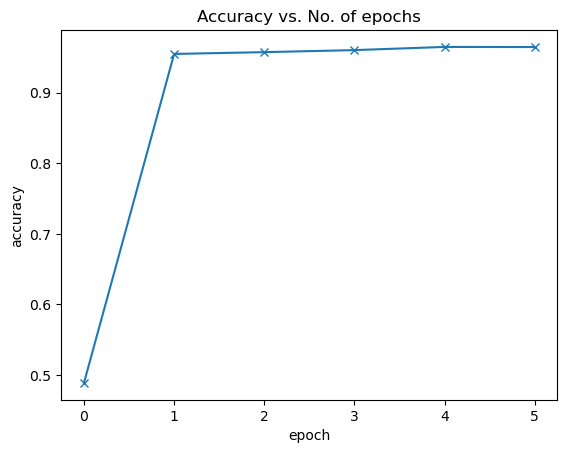

In [24]:
plot_accuracies(history)


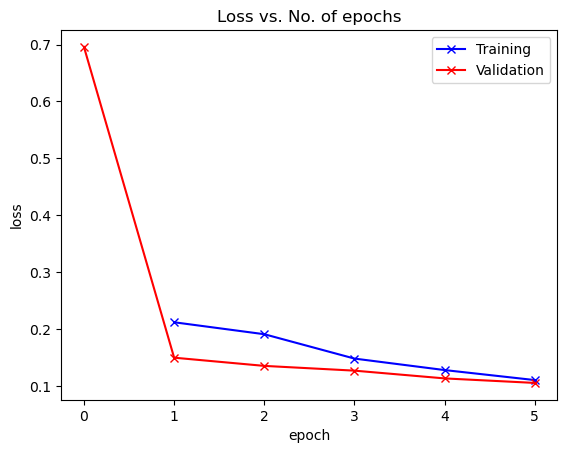

In [25]:
plot_losses(history)


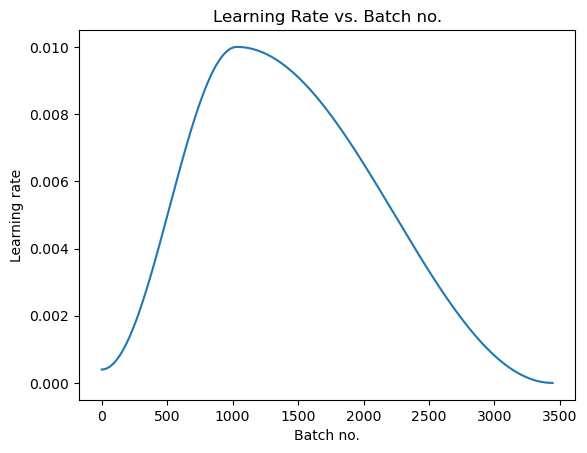

In [26]:
plot_lrs(history)

## Saving the model

In [27]:
# saving to the kaggle working directory
PATH = './Malaria-model.pth'  
torch.save(model.state_dict(), PATH)


## Hotspot_Function

In [38]:

def get_hotspot(image_path, model):
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])
    image_tensor = transform(image).unsqueeze(0)

    # Perform inference
    image_tensor.requires_grad = True
    logits = model(image_tensor)
    probs = nn.functional.softmax(logits, dim=1)
    predicted_class = torch.argmax(probs, dim=1)

    # Compute gradients
    model.zero_grad()
    logits[0, predicted_class].backward()

    # Compute the heatmap
    gradients = image_tensor.grad[0].detach().cpu().numpy()
    heatmap = np.mean(gradients, axis=0)

    # Normalize the heatmap
    heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap))

    # Resize the heatmap to match the original image size
    heatmap = cv2.resize(heatmap, (image.width, image.height))

    # Apply colormap to the heatmap (optional)
    heatmap = cv2.applyColorMap(np.uint8(heatmap * 255), cv2.COLORMAP_JET)

    # Overlay the heatmap on the original image
    image_np = np.array(image)
    overlay = cv2.addWeighted(image_np, 0.7, heatmap, 0.3, 0)

    # Display the original image and the overlayed image side by side
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(image_np)
    axs[0].set_title("Original Image")
    axs[0].axis('off')
    axs[1].imshow(overlay)
    axs[1].set_title("Hotspot Overlayed Image")
    axs[1].axis('off')

    # Print the predicted output class
    print("Predicted Class:", predicted_class.item())

    plt.show()



Predicted Class: 0


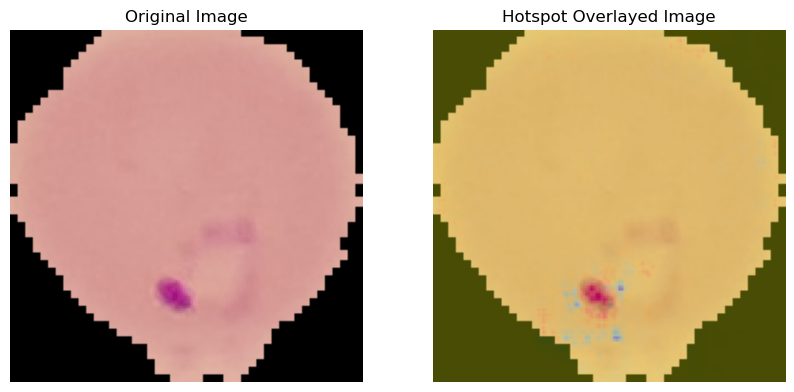

In [42]:
model = CNN(3, 2) 
model.load_state_dict(torch.load('./Malaria-model.pth'))  
model.eval()
image_path = data_dir +'/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_168.png' 
get_hotspot(image_path, model)

## Conclusion

*We got 96.4% accuracy*

In this notebook, we investigated the effectiveness of Convolutional Neural Networks (CNN) for our task. By leveraging the hierarchical structure of the data, CNNs proved to be powerful models for image classification.

We experimented with different learning rates to optimize the performance of our CNN model. Through careful tuning, we identified an optimal learning rate that led to improved accuracy and convergence speed.

The combination of the CNN architecture and the appropriate learning rate allowed us to achieve promising results on our dataset. This highlights the importance of model selection and hyperparameter tuning in deep learning tasks.

Overall, our findings demonstrate the effectiveness of CNNs and emphasize the significance of selecting an appropriate learning rate to maximize model performance.


